### Cats vs Dogs classification using a convnet with a dropout layer and data augmentation

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus=tf.config.list_physical_devices('GPU')

#configure the GPU(s), to use the memory necessary up to the GPU max memory
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
            print(tf.config.experimental.get_device_details(gpu))
        logi_gpu=tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus),'Physical GPU(s)',len(logi_gpu),'Logical GPU(s)')
        
    except RuntimeError as e:
        print(e)
print("Is gpu available?, :",tf.test.is_gpu_available(cuda_only=False,min_cuda_compute_capability=None))

Num GPUs Available:  1
{'device_name': 'NVIDIA GeForce RTX 2060', 'compute_capability': (7, 5)}
1 Physical GPU(s) 1 Logical GPU(s)
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is gpu available?, : True


In [32]:
# it will be used 2000 images for trainign, 1000 images for validation and
#1000 images for testing
import os
import random
import shutil

def create_dataset(origin,folder,ratio,num_ob,name_folders,clas,seed=0):
    #origin where the data is going to be extracted
    #folder where the data is going to be copied
    #ratio how many classes and it's respective representative on the num_ob
    #num_ob is the numeber of objects where is going to be extracted
    #seed is the random generator seed
    #clas is the number of classes and what determines a class (name, number,...)
    if len(ratio)!=len(name_folders):
        raise("Ratio and name_folders must have same dimmensions")
    if sum(ratio)!=100:
        raise("Ratio should sum 100%")
    if not os.path.isdir(origin):
        raise("Origin is not a proper directory")


    random.seed(seed)
    I_obj=os.listdir(origin)

    for i,r in zip(name_folders,ratio):
        dir=os.path.join(folder,i)
        os.makedirs(dir,exist_ok=True)#create diretory if it doesn't exists

        files=num_ob*r//100#files per folder
        if len(clas)>1:
            for j,c in enumerate(clas):#iterate throghout the different classes
                files_c=files//len(clas)#files per class
                cont=0
                dir_c=os.path.join(dir,c)
                os.makedirs(dir_c,exist_ok=True)
                while cont<files_c:#pass 
                    f=random.choice(I_obj)
                    if f.startswith(c):
                        of=os.path.join(origin,f)
                        ff=os.path.join(dir_c,f)
                        if os.path.exists(of) and os.path.exists(ff)==False:
                            cont+=1
                            shutil.copy(of,ff)
                print("Finish copying {} elements to folder {},class:{}".format(cont,i,c))
        else:
            cont=0
            while cont<num_ob:#pass 
                f=random.choice(I_obj)
                of=os.path.join(origin,f)
                ff=os.path.join(dir,f)
                if os.path.exists(of) and os.path.exists(ff)==False:
                    cont+=1
                    shutil.copy(of,ff)
            print("Finish copying {} elements to folder {},class:{}".format(cont,i,c))
        
    print("Finish copying all elements")         
         
create_dataset("CatsvsDogs_dataset\\train",
               "CatsvsDogs_small_dataset",
               [50,25,25],
               4000,
               ("Train","Validation","Test"),
               ("cat","dog"),
               seed=0)


Finish copying 1000 elements to folder Train,class:cat
Finish copying 1000 elements to folder Train,class:dog
Finish copying 500 elements to folder Validation,class:cat
Finish copying 500 elements to folder Validation,class:dog
Finish copying 500 elements to folder Test,class:cat
Finish copying 500 elements to folder Test,class:dog
Finish copying all elements


In [2]:
#using imagedatagenerator to read images from directory
from keras.preprocessing.image import ImageDataGenerator
train_d=ImageDataGenerator(rescale=1./255)
test_d=ImageDataGenerator(rescale=1./255)
val_d=ImageDataGenerator(rescale=1./255)
train_g=train_d.flow_from_directory("CatsvsDogs_small_dataset\Train",
                                    target_size=(150,150),batch_size=20,
                                    class_mode="binary")
val_g=val_d.flow_from_directory("CatsvsDogs_small_dataset\Validation",
                                    target_size=(150,150),batch_size=20,
                                    class_mode="binary")
test_g=test_d.flow_from_directory("CatsvsDogs_small_dataset\Test",
                                    target_size=(150,150),batch_size=20,
                                    class_mode="binary")
print("Data batch shape:",train_g[0][0].shape)
print("labels batch shape:",train_g[0][1].shape)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1001 images belonging to 2 classes.
Data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


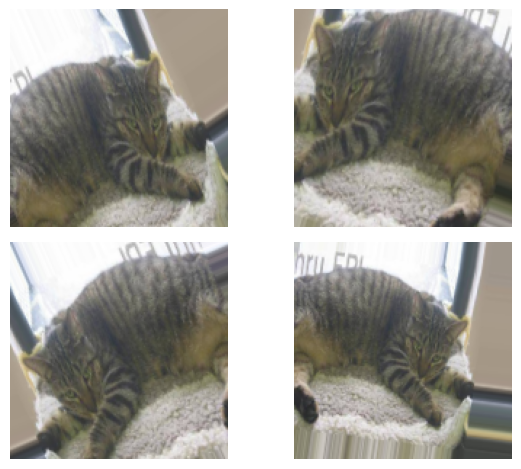

In [6]:
#using data augmentation as the previous plots represent overfitting
from keras.preprocessing import image
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
datagen=ImageDataGenerator(rotation_range=40,width_shift_range=0.2,
                           height_shift_range=0.2,shear_range=0.2,
                           zoom_range=0.2,horizontal_flip=True,fill_mode="nearest")
fnames=[os.path.join("CatsvsDogs_small_dataset\\Train\\cat",fname) for
        fname in os.listdir("CatsvsDogs_small_dataset\\Train\\cat")]
img_path=fnames[3]
img=cv2.resize(cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB),(150,150))
img=img.reshape((1,)+img.shape)
i=0
f,ax=plt.subplots(2,2)
k=0
j=0
for batch in datagen.flow(img,batch_size=1):
    b=batch[0]
    ax[k,j].imshow(b.astype("uint8"))
    ax[k,j].axis("off")
    k+=1
    if k%2==0:
        j+=1
        k=0
    i+=1
    if i%4==0:
        break
plt.tight_layout()
plt.show()


In [9]:
#Defining a new convnet with dropout
from keras import models,layers,optimizers
dr_model=models.Sequential()
dr_model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(150,150,3)))
dr_model.add(layers.MaxPooling2D((2,2)))
dr_model.add(layers.Conv2D(64,(3,3),activation="relu"))
dr_model.add(layers.MaxPooling2D((2,2)))
dr_model.add(layers.Conv2D(128,(3,3),activation="relu"))
dr_model.add(layers.MaxPooling2D((2,2)))
dr_model.add(layers.Conv2D(128,(3,3),activation="relu"))
dr_model.add(layers.MaxPooling2D((2,2)))
dr_model.add(layers.Flatten())
dr_model.add(layers.Dropout(0.5))
dr_model.add(layers.Dense(512,activation="relu"))
dr_model.add(layers.Dense(1,activation="sigmoid"))
print(dr_model.summary())
dr_model.compile(loss="binary_crossentropy",
                 optimizer=optimizers.RMSprop(lr=1e-4),
                 metrics=["acc"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

c:\Users\simon\.conda\envs\obj_de\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
#training the new convnet
train_aug=ImageDataGenerator(rescale=1./255,rotation_range=40,width_shift_range=0.2,
                             height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,
                             horizontal_flip=True)#data augmentation technique
train_g_aug=train_aug.flow_from_directory("CatsvsDogs_small_dataset\Train",
                                          target_size=(150,150),batch_size=32,
                                          class_mode="binary")#creating the generator
print(train_g_aug.total_batches_seen)
history_aug=dr_model.fit(train_g_aug,epochs=100,steps_per_epoch=63,
                         validation_data=val_g,validation_steps=50)

Found 2000 images belonging to 2 classes.
0
Epoch 1/100
63/63 [==============================] - 15s 169ms/step - loss: 0.6961 - acc: 0.4900 - val_loss: 0.6908 - val_acc: 0.5020
Epoch 2/100
63/63 [==============================] - 10s 163ms/step - loss: 0.6891 - acc: 0.5420 - val_loss: 0.6987 - val_acc: 0.5000
Epoch 3/100
63/63 [==============================] - 10s 163ms/step - loss: 0.6784 - acc: 0.5645 - val_loss: 0.6635 - val_acc: 0.5940
Epoch 4/100
63/63 [==============================] - 10s 163ms/step - loss: 0.6622 - acc: 0.6045 - val_loss: 0.7268 - val_acc: 0.5200
Epoch 5/100
63/63 [==============================] - 10s 158ms/step - loss: 0.6540 - acc: 0.6015 - val_loss: 0.7027 - val_acc: 0.5590
Epoch 6/100
63/63 [==============================] - 10s 160ms/step - loss: 0.6475 - acc: 0.6175 - val_loss: 0.6449 - val_acc: 0.6120
Epoch 7/100
63/63 [==============================] - 10s 157ms/step - loss: 0.6364 - acc: 0.6165 - val_loss: 0.6711 - val_acc: 0.6190
Epoch 8/100
63/63 

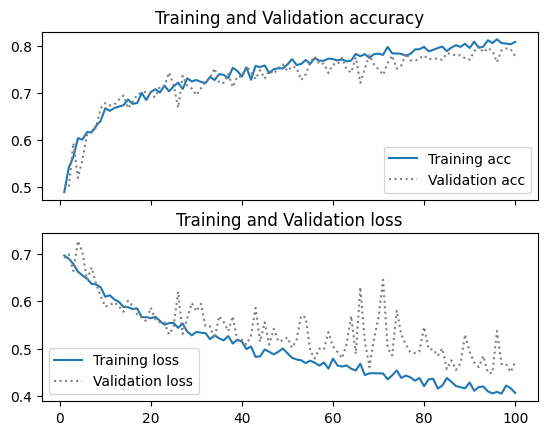

In [11]:
acc_aug=history_aug.history["acc"]
val_acc_aug=history_aug.history["val_acc"]
loss_aug=history_aug.history["loss"]
val_loss_aug=history_aug.history["val_loss"]
epochs=range(1,len(acc_aug)+1)

f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
ax1.plot(epochs,acc_aug,label="Training acc")
ax1.plot(epochs,val_acc_aug,color="grey",ls=":",label="Validation acc")
ax1.set_title("Training and Validation accuracy")
ax1.legend()
ax2.plot(epochs,loss_aug,label="Training loss")
ax2.plot(epochs,val_loss_aug,color="grey",ls=":",label="Validation loss")
ax2.set_title("Training and Validation loss")
ax2.legend()

plt.show()

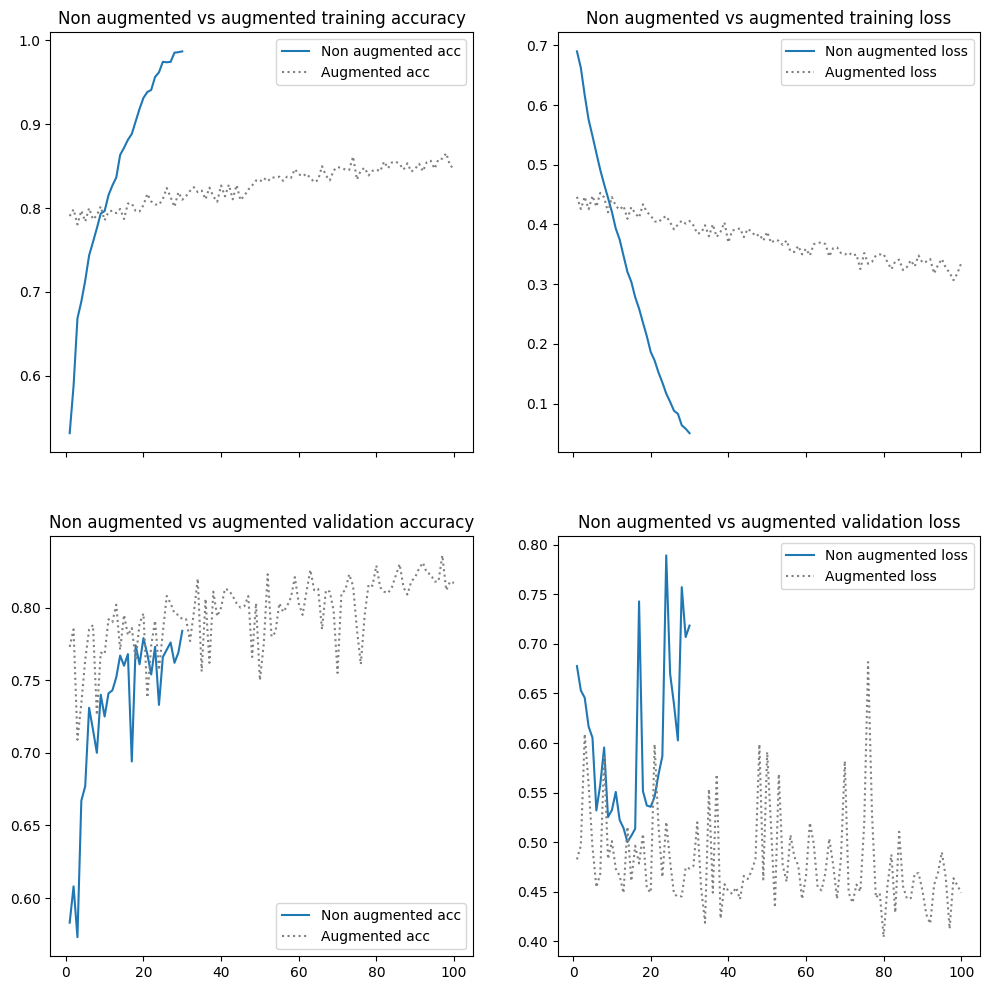

In [100]:

f,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,sharex=True,figsize=(12,12))
ax1.plot(range(1,len(acc)+1),acc,label="Non augmented acc")
ax1.plot(epochs,acc_aug,color="grey",ls=":",label="Augmented acc")
ax1.set_title("Non augmented vs augmented training accuracy")
ax1.legend()
ax3.plot(range(1,len(acc)+1),val_acc,label="Non augmented acc")
ax3.plot(epochs,val_acc_aug,color="grey",ls=":",label="Augmented acc")
ax3.set_title("Non augmented vs augmented validation accuracy")
ax3.legend()

ax2.plot(range(1,len(acc)+1),loss,label="Non augmented loss")
ax2.plot(epochs,loss_aug,color="grey",ls=":",label="Augmented loss")
ax2.set_title("Non augmented vs augmented training loss")
ax2.legend()
ax4.plot(range(1,len(acc)+1),val_loss,label="Non augmented loss")
ax4.plot(epochs,val_loss_aug,color="grey",ls=":",label="Augmented loss")
ax4.set_title("Non augmented vs augmented validation loss")
ax4.legend()

plt.show()

1/1 [==============================] - 1s 500ms/step


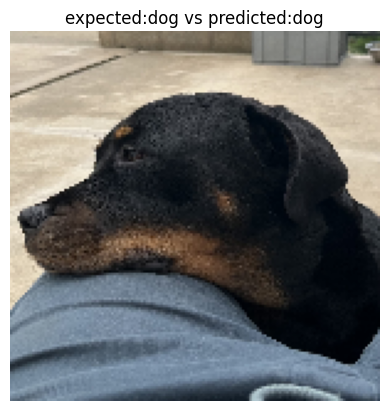

In [12]:
#testing model prediction with my dog's picture
img_t=img=cv2.resize(cv2.cvtColor(cv2.imread("mine.jpg"),cv2.COLOR_BGR2RGB),(150,150))
def get_key(dic,item):
    item=int(item)
    for key,value in dic.items():
        if value==item:
            return key
    return None
        

plt.imshow(img_t)
label_pre=dr_model.predict(img_t.reshape((1,)+img_t.shape))

plt.title("expected:dog vs predicted:{}".
          format(get_key(train_g_aug.class_indices,label_pre[0][0])))
plt.axis("off")
plt.show()
#save model 
dr_model.save("CatsvsDogs_dropout_model.h5")

In [13]:
#Testing the small model with the test images
test_loss,test_acc=dr_model.evaluate(test_g)
print("Test accuracy: {:.2f}".format(test_acc))

51/51 [==============================] - 2s 29ms/step - loss: 0.4800 - acc: 0.7912
Test accuracy: 0.79
